In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

import numpy as np
import pandas as pde_diff_new
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *
from solvel0 import solvel0, refine_solvel0

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat("/Users/pongpisit/Desktop/research/examples/pde/datasets/gray_scott_2d_maxt10_V2.mat")
# data = sio.loadmat("../Datasets/reaction_diffusion_rudy.mat")

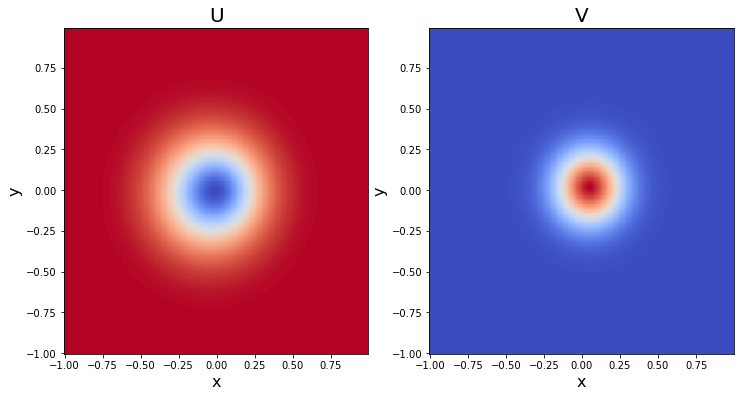

In [3]:
t = data['tspan'][0,:]
x = data['u_grid'][0,:]
y = data['v_grid'][0,:]
u_sol = data['usol']
v_sol = data['vsol']

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(x, y)
subplot(1,2,1)
pcolor(xx,yy,u_sol[:,:,10],cmap='coolwarm')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,v_sol[:,:,10],cmap='coolwarm')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

In [4]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

In [5]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=False,
    include_interaction=True, 
    include_bias=True,
    cache=True
)

### Noiseless ###
u_noisy = u.copy()

### Add noise ###
noise_lv = 0 # 1e-1
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(*u_noisy.shape)
u_noisy = u_noisy + domain_noise

In [6]:
# thres = 1e-4 # 1e-3
# # optimizer = ps.STLSQ(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# optimizer = ps.SR3(threshold=thres, normalize_columns=True, max_iter=100)
# # optimizer = ps.MIOSR(target_sparsity=2*7, fit_intercept=False, normalize_columns=True)

# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
#                  cache=True, feature_names=['u', 'v'])
# model.fit(u_noisy, ensemble=False, library_ensemble=True)
# model.print()

# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
# np.save("./IPI_output_files/X_pre_V2_clean.npy", X_pre)
# np.save("./IPI_output_files/y_pre_V2_clean.npy", y_pre)
# # np.save("./IPI_output_files/feature_names.npy", model.get_feature_names())

In [7]:
# X_pre = np.load("./IPI_output_files/X_pre_clean.npy")
# y_pre = np.load("./IPI_output_files/y_pre_clean.npy")

X_pre = np.load("./IPI_output_files/X_pre_V2_clean.npy")
y_pre = np.load("./IPI_output_files/y_pre_V2_clean.npy")

u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]; del y_pre
feature_names = np.load("./IPI_output_files/feature_names.npy")

In [8]:
solve_grb = solvel0(X_pre, u_pre, intercept=False, refine=True, max_complexity=10)
# print(solve_grb)
solve_grb_normal = solvel0(X_pre, u_pre, is_normal=True, intercept=False, refine=True, max_complexity=10)
# print(solve_grb_normal)
solve_grb = refine_solvel0(solve_grb+solve_grb_normal, (X_pre, u_pre)); del solve_grb_normal
solve_grb = sorted([e[0] for e in solve_grb.track.values()], key=len)
solve_grb

  0%|                                                                            | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.21it/s]


Call backward_refinement...


100%|███████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.53s/it]


Call backward_refinement...


[(15,),
 (9, 65),
 (5, 9, 15),
 (2, 5, 9, 15),
 (0, 1, 5, 9, 15),
 (0, 1, 5, 6, 9, 15),
 (0, 1, 2, 5, 6, 9, 15),
 (2, 5, 6, 9, 15, 20, 56, 59),
 (2, 5, 6, 9, 15, 20, 23, 56, 59),
 (8, 9, 15, 36, 66, 67, 68, 69, 70, 72)]

In [9]:
n_top = 15
potential_indices = sum([Counter(e) for e in solve_grb])
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:n_top]
potential_indices = sorted(potential_indices)
if 0 not in potential_indices:
    potential_indices = [0] + potential_indices
potential_indices

[0, 1, 2, 5, 6, 8, 9, 15, 20, 23, 36, 56, 59, 65, 66]

In [10]:
potential_feature_names = feature_names[potential_indices]
brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], u_pre, max_support_size=10)

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it]


In [11]:
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))

In [12]:
BICs = []
uncertainties = []
for effective_indices in brute_solve[-1]:
    effective_indices = [map2pysindy[ei] for ei in effective_indices]
    fit_res = sm.OLS(u_pre, X_pre[:, effective_indices]).fit()    
    BICs.append(fit_res.bic)
    uncertainties.append(sum(fit_res.bse))
BICs = np.array(BICs)
uncertainties = np.array(uncertainties)/min(uncertainties)
uncertainties

array([5.55401889e+02, 4.68105723e+02, 1.31737203e+04, 8.22082039e+03,
       1.00000000e+00, 1.00923669e+00, 5.08729304e+00, 5.66693403e+00,
       6.49612439e+00, 7.08587885e+00])

In [13]:
def increasing_values_indices(arr):
    mini = max(arr)+1; out = []
    for i, e in enumerate(arr):
        if e < mini:
            mini = e
            out.append(i)
    return np.array(out)

10
6
6
5
5
5
Optimal complexity = 5


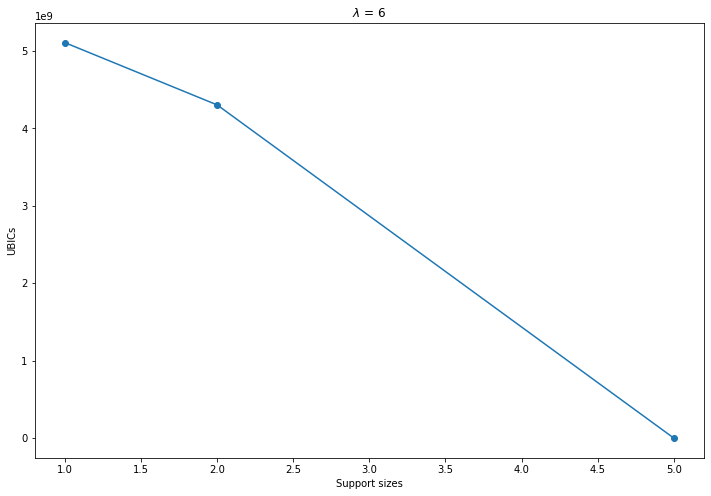

In [14]:
lam = 0; delta = 2
UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
bc = []
while True:
    UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
    print(np.argmin(UBICs)+1)
    bc.append(np.argmin(UBICs)+1)
    bcl = bc[-3:]
    if len(bc) > 2 and (bcl[0] == bcl[1] == bcl[2]):
        bc = bcl[0]
        break
    lam += delta
    
lam -= 2*delta
print("Optimal complexity =", bc)
UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
xaxis = increasing_values_indices(UBICs)+1
yaxis = (UBICs-min(UBICs))[increasing_values_indices(UBICs)]
plt.plot(xaxis, yaxis, '-o')
plt.ylabel("UBICs")
plt.xlabel("Support sizes")
plt.title(f"$\lambda$ = {lam}")
plt.show()

In [15]:
# [0, 1, 5, 9, 15]
# for effective_indices in brute_solve[-1]:
#     effective_indices = [map2py sindy[ei] for ei in effective_indices]
#     print(effective_indices)

best_subsets = [[map2pysindy[ei] for ei in effective_indices] 
                for effective_indices in brute_solve[-1]]
best_subsets

[[15],
 [9, 65],
 [5, 9, 15],
 [2, 5, 9, 15],
 [0, 1, 5, 9, 15],
 [0, 1, 5, 9, 15, 65],
 [0, 1, 5, 9, 15, 20, 65],
 [0, 1, 5, 6, 9, 15, 56, 65],
 [0, 1, 5, 6, 9, 15, 36, 56, 65],
 [0, 1, 5, 6, 9, 15, 20, 36, 65, 66]]

10
10
6
6
6
Optimal complexity = 6


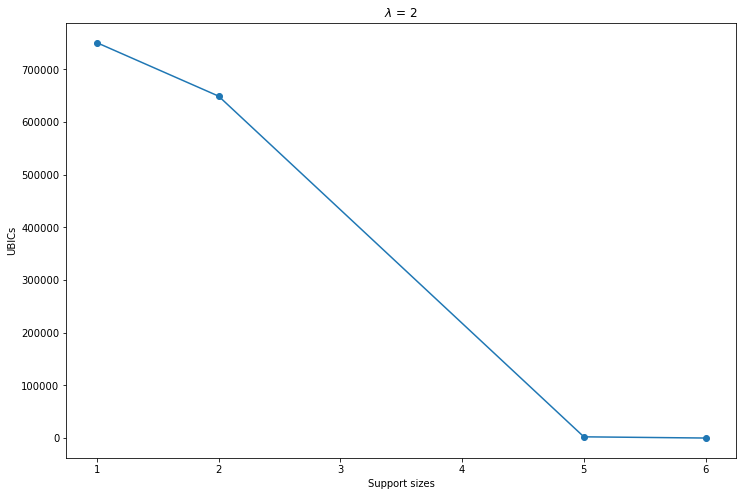

In [16]:
lam = 0; delta = 1
UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
bc = []
while True:
    UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
    print(np.argmin(UBICs)+1)
    bc.append(np.argmin(UBICs)+1)
    bcl = bc[-3:]
    if len(bc) > 2 and (bcl[0] == bcl[1] == bcl[2]):
        bc = bcl[0]
        break
    lam += delta
    
lam -= 2*delta
print("Optimal complexity =", bc)
UBICs = BICs+(10**lam)*log(len(u_pre))*uncertainties
xaxis = increasing_values_indices(UBICs)+1
yaxis = (UBICs-min(UBICs))[increasing_values_indices(UBICs)]
plt.plot(xaxis, yaxis, '-o')
plt.ylabel("UBICs")
plt.xlabel("Support sizes")
plt.title(f"$\lambda$ = {lam}")
plt.show()

In [17]:
from UBIC import UBIC, UBICs, baye_uncertainties, log_like_value

In [18]:
d_BICs = BICs
d_complexities = [i+1 for i in range(len(BICs))]

d_BICs, d_complexities

(array([-201164.49655362, -222314.28269257, -241798.82108174,
        -258741.80402299, -439010.00624453, -441314.43349922,
        -443116.7979915 , -443599.35144591, -443930.59107168,
        -444302.44277626]),
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from k_means_constrained import KMeansConstrained

points = np.vstack((d_BICs, d_complexities)).T
# size_max = len(bic_scores)-1
size_max = len(d_BICs)//2+1
clf = KMeansConstrained(
    n_clusters=2, size_min=1, size_max=size_max, 
    random_state=0, 
); clf.fit(points)
silhouette_avg = silhouette_score(points, clf.labels_)
clf.labels_,  clf.cluster_centers_, silhouette_avg

(array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([[-4.42545604e+05,  7.50000000e+00],
        [-2.31004851e+05,  2.50000000e+00]]),
 0.9323366492912669)

In [20]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, u_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=1+1/3, n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[2.75074556e+04 1.50455209e+04 1.67014836e+04 7.70201472e+03
 1.00000000e+00 1.00918802e+00 5.08654840e+00 5.66584555e+00
 6.49451939e+00 7.08379167e+00]
0 ---> 10
1.3333333333333333 ---> 10
2.6666666666666665 ---> 6
4.0 ---> 6
5.333333333333333 ---> 5
6.666666666666666 ---> 5
7.999999999999999 ---> 5
[5.45830542e+10 2.98547203e+10 3.31406403e+10 1.52829082e+10
 1.54529767e+06 1.56122510e+06 9.65016027e+06 1.07991815e+07
 1.24431941e+07 1.36121198e+07]
The optimal complexity is currently at the support sizes of 5.


(array([5.45830542e+10, 2.98547203e+10, 3.31406403e+10, 1.52829082e+10,
        1.54529767e+06, 1.56122510e+06, 9.65016027e+06, 1.07991815e+07,
        1.24431941e+07, 1.36121198e+07]),
 4,
 5.333333333333333)

In [21]:
_, _, b_uns = baye_uncertainties(best_subsets, (X_pre, u_pre), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in best_subsets:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], u_pre, rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, u_pre)/np.log(len(u_pre))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.log10(lower_bounds/b_uns))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

4.377123183990541

In [22]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (X_pre, u_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam,
                     delta=delta, n_lams=n_lams)

n_lams = 3
Using baye_uncertainties
[2.75074556e+04 1.50455209e+04 1.67014836e+04 7.70201472e+03
 1.00000000e+00 1.00918802e+00 5.08654840e+00 5.66584555e+00
 6.49451939e+00 7.08379167e+00]
0 ---> 10
1.4590410613301803 ---> 10
2.9180821226603606 ---> 6
4.377123183990541 ---> 6
[ 2.09600159e+08  1.14530945e+08  1.27141606e+08  5.84850731e+07
 -4.31382935e+05 -4.33617285e+05 -4.04321331e+05 -4.00385544e+05
 -3.94396429e+05 -3.90273859e+05]
5 to 6 complexity may not be worthy with percent_improve = 0.005249145171616398.
Staying at 5 complexity...
The optimal complexity is currently at the support sizes of 5.


In [23]:
lam

2.9180821226603606

In [24]:
tau = 3
thres = 0.02

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    com = len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+10], u_pre)/np.log(len(u_pre))-com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/b_uns))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    imp = abs((b_bics[now_bc]-b_bics[last_bc])/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc, best_bc

4 <---> 5 0.005249145171616398


(4.6635691671,
 array([ 1.16758306e+10,  6.38611824e+09,  7.08900176e+09,  3.26899923e+09,
        -1.45421117e+04, -1.29465208e+04,  1.71595969e+06,  1.96137018e+06,
         2.31278438e+06,  2.56253969e+06]),
 4,
 4)

4


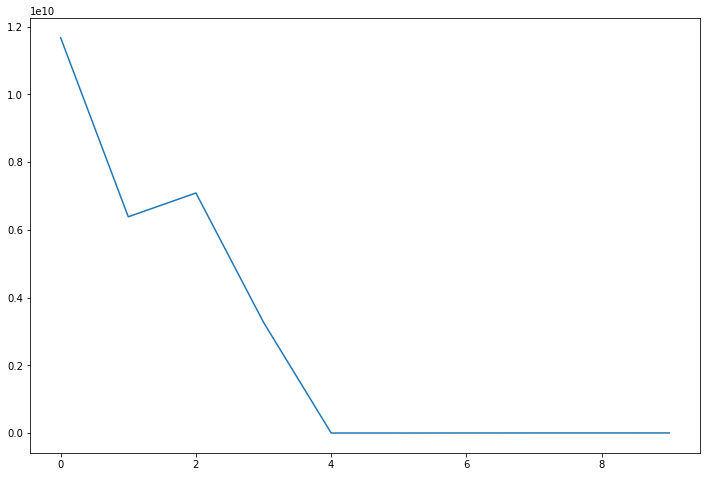

In [27]:
print(np.argmin(last_ubic))
plt.plot(last_ubic); plt.show()

2


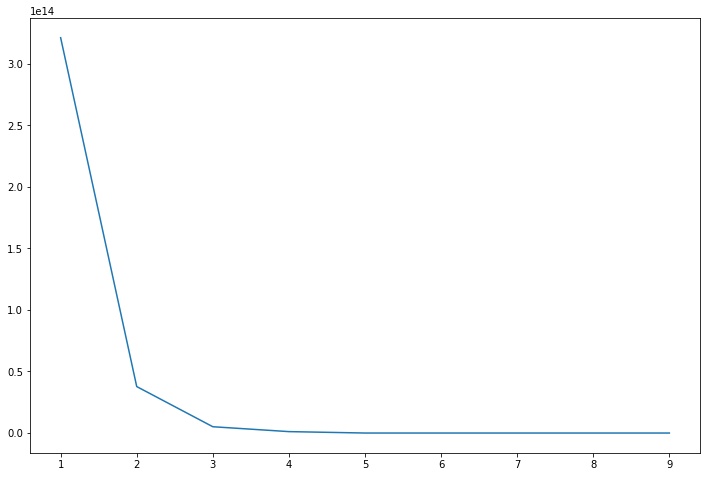

In [28]:
ols_models = [sm.OLS(u_pre, X_pre[:, efi]).fit() for efi in best_subsets]
f_res = sm.stats.anova_lm(*ols_models, test="F") # "F", "Chisq"", "Cp"
print(np.argmax(f_res.F)+1)
plt.plot( f_res.F[1:]); plt.show()

In [29]:
f_res

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9999.0,1.073155e-06,0.0,NaN,NaN,NaN
1,9998.0,1.293418e-07,1.0,9.438134e-07,3.211707e+14,0.000000e+00
2,9997.0,1.841350e-08,1.0,1.109283e-07,3.774785e+13,0.000000e+00
3,9996.0,3.379962e-09,1.0,1.503353e-08,5.115768e+12,0.000000e+00
4,9995.0,5.006836e-17,1.0,3.379962e-09,1.150169e+12,0.000000e+00
5,9994.0,3.972678e-17,1.0,1.034158e-17,3.519141e+03,0.000000e+00
6,9993.0,3.314421e-17,1.0,6.582570e-18,2.239986e+03,0.000000e+00
7,9992.0,3.155372e-17,1.0,1.590484e-18,5.412267e+02,1.237398e-116
8,9991.0,3.049756e-17,1.0,1.056166e-18,3.594031e+02,9.081347e-79
9,9990.0,2.935727e-17,1.0,1.140282e-18,3.880272e+02,8.929678e-85


In [30]:
alpha = 1e-3
percent_improves = []
for i in range(len(best_subsets)): 
    bs = np.array(best_subsets[i])
    ref_model = sm.OLS(u_pre, X_pre[:, bs]).fit()
    count_better = 0; count_worse = 0
    for e in set(range(X_pre.shape[-1]))-set(bs):
        whe = np.where(bs < e)[0]
        if len(whe) > 0: res = np.insert(bs, max(whe)+1, e)
        else: res = np.insert(bs, 0, e)
        f_res = sm.stats.anova_lm(ref_model, sm.OLS(u_pre, X_pre[:, res]).fit())
        pv = f_res["Pr(>F)"][1]
        if pv < alpha: count_better += 1
        else: count_worse += 1
    percent_improve = count_better/(count_better+count_worse)
    if percent_improve < 0.51:
        print('-'*50)
        print(len(bs), len(res), percent_improve)
        break
    print(len(bs), len(res), percent_improve)

1 2 0.9210526315789473
2 3 0.9733333333333334
3 4 0.9594594594594594
4 5 0.9863013698630136
5 6 0.8611111111111112
6 7 0.9577464788732394
7 8 0.8285714285714286
8 9 0.6521739130434783
9 10 0.8088235294117647
10 11 0.7611940298507462


In [31]:
from misc import h5file

In [32]:
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
# best_subsets

In [33]:
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))

best_subsets_v = [[5],
                 [35, 71],
                 [6, 35, 71],
                 [2, 5, 10, 16],
                 [2, 5, 10, 16, 40],
                 [2, 5, 10, 16, 40, 76],
                 [0, 2, 5, 10, 16, 40, 76],
                 [2, 5, 10, 16, 40, 71, 72, 76],
                 [0, 2, 5, 10, 16, 40, 71, 72, 76],
                 [0, 2, 5, 10, 16, 35, 40, 71, 72, 76]]

for i in range(len(best_subsets_v)):
    tmp[i:i+1, :][0, best_subsets_v[i]] = 1.0
best_subsets_v = tmp.astype(np.float32)
best_subsets_v

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [34]:
pms_data = {"X_pre": X_pre, 
            "u_pre": u_pre, 
            "v_pre": v_pre,
            "best_subsets_u": best_subsets, 
            "best_subsets_v": best_subsets_v}

# h5file(file_path="./IPI_output_files/GS_PMS_data.h5", cdict=pms_data, mode='w')

pms_data

{'X_pre': array([[ 2.21142425e-03,  2.18466245e-03,  1.91605003e-05, ...,
         -8.16905841e-11, -9.00662924e-09, -1.00380490e-06],
        [ 2.21142425e-03,  2.19656180e-03,  3.93695568e-06, ...,
          3.33642977e-14,  1.86687577e-11,  1.06235730e-08],
        [ 2.12296728e-03,  2.10732817e-03,  6.71776265e-06, ...,
         -2.18956925e-12, -5.92500633e-10, -1.67646443e-07],
        ...,
        [ 2.21142425e-03,  2.17614281e-03,  3.10185300e-05, ...,
         -2.98939544e-10, -1.97757358e-08, -1.32477894e-06],
        [ 2.21142425e-03,  2.20278405e-03,  1.28896109e-06, ...,
          9.83405736e-15,  1.53784408e-11,  2.48446473e-08],
        [ 2.12296728e-03,  2.11520632e-03,  5.70542860e-07, ...,
          8.87524548e-16,  2.59032472e-12,  8.18547585e-09]]),
 'u_pre': array([[ 8.55808465e-07],
        [-1.57277370e-06],
        [-3.27619745e-06],
        ...,
        [ 2.21252107e-06],
        [-1.92692460e-06],
        [-2.31245744e-06]]),
 'v_pre': array([[-1.21584408e-06]